In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns
#import matplotlib

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


DIR_PATH = './'

train = pd.read_csv("train.csv", encoding="ascii") 
macro = pd.read_csv("macro.csv", encoding="ascii")
test =  pd.read_csv("test.csv", encoding="ascii") 


In [3]:
all_data1 = pd.concat((train.loc[:,'timestamp':'price_doc'],
                      test.loc[:,'timestamp':'market_count_5000']))
#all_data1['unitprice'] = all_data1.price_doc/all_data1.full_sq

In [4]:
macro_imp = ['timestamp', 'oil_urals', 'cpi', 'usdrub', 'rts', 'mortgage_rate', 'balance_trade', 'brent', 'micex', 'micex_cbi_tr', 'micex_rgbi_tr', 'fixed_basket']
macro_usefeat = macro[macro_imp]

all_data = pd.merge(all_data1, macro_usefeat, on = 'timestamp', how='left')


In [5]:
#log transform the target:
#train['price_doc'] = np.log1p(train['price_doc'])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.5]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())


X_train = all_data[:train.shape[0]]

X_test = all_data[train.shape[0]:]
y = X_train.price_doc

print X_train.shape
print X_test.shape
print X_train.columns.values

(30471, 1898)
(7662, 1898)
[u'0_13_all' u'0_13_female' u'0_13_male' ..., u'timestamp_2016-05-30'
 u'water_1line_no' u'water_1line_yes']


In [6]:
for column in train.columns :
    if train[column].nunique() < 60 :
        print column, np.array(sorted(train[column].unique()))
    else :
        print column, train[column].nunique()

id 30471
timestamp 1161
full_sq 211
life_sq 175
floor [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  nan  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  36.  37.  38.  41.  44.  77.]
max_floor [  nan    0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.
   11.   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.
   23.   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.
   36.   37.   38.   39.   40.   41.   42.   44.   45.   47.   48.   57.
   99.  117.]
material [ nan   1.   2.   3.   4.   5.   6.]
build_year 119
num_room [ nan   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  17.  19.]
kitch_sq 74
state [ nan   1.   2.   3.   4.  33.]
product_type [u'Investment' u'OwnerOccupier']
sub_area 146
area_m 146
raion_popul 146
green_zone_part 146
indust_part 132
children_preschool 146
preschool_quota 121
preschool_education_centers_raion [ 0  1  2  3  4  5  6  7 

In [7]:
from sklearn.model_selection import train_test_split


train_local, validation = train_test_split(
    X_train, 
    test_size = 0.2, 
    random_state = 0
)

print X_train.shape
print train_local.shape


(30471, 1898)
(24376, 1898)


In [10]:
from sklearn.metrics import mean_squared_error

scores = []
#print validation.shape[0]
for C in np.linspace(4500000, 8500000, 300) :
    p = np.ones(validation.shape[0]) * C
    score = mean_squared_error(p, validation.price_doc)
    scores.append((score, C))

print 'Min error: %.2f, optimal constant prediction: %.2f' % min(scores)
print 'Mean target: %.2f, median target: %.2f' % (validation['price_doc'].mean(), validation['price_doc'].median())

Min error: 20249859488436.80, optimal constant prediction: 4500000.00
Mean target: 15.61, median target: 15.65


In [11]:
features = np.array([column for column in X_train.columns if column != 'price_doc'])
features

array([u'0_13_all', u'0_13_female', u'0_13_male', ...,
       u'timestamp_2016-05-30', u'water_1line_no', u'water_1line_yes'], 
      dtype='<U39')

In [12]:
import os
from pylightgbm.models import GBMRegressor
os.environ['LIGHTGBM_EXEC'] = "/Users/Lakshmi/LightGBM/lightgbm"


In [13]:
offset = 50

#### Using lightgbm FIT

In [14]:
model = GBMRegressor(
    num_threads=-1,
    learning_rate = 0.03,
    num_iterations = 1000, # does no of iteration increase help? 
    verbose = False, 
    early_stopping_round = 50,
    feature_fraction = 0.8,
    bagging_fraction = 0.8,
)

model.fit(
    train_local[features].values, 
    train_local['price_doc'].values + offset, 
    test_data = [(
        validation[features].values, 
        validation['price_doc'].values + offset
    )]
    
)

In [15]:
p = model.predict(validation[features].values) - offset
mean_squared_error(p, validation['price_doc'])

0.2115797605662498

In [32]:
scores = []
for prediction_multiplicator in np.linspace(0.95, 1.05, 101) :
    score = mean_squared_error(p * prediction_multiplicator, validation['price_doc'])
    scores.append((score, prediction_multiplicator))

M = min(scores)[1]
validation.loc[:, 'price_doc_lightgbm'] = p * M
print 'Min error: %.2f, optimal prediction multiplicator: %.3f' % min(scores)

Min error: 0.21, optimal prediction multiplicator: 1.000


In [17]:
model = GBMRegressor(
    num_threads=-1,
    learning_rate = 0.03,
    num_iterations = int(model.best_round / 0.9), 
    verbose = False, 
    early_stopping_round = 50,
    feature_fraction = 0.8,
    bagging_fraction = 0.8,
)

In [18]:
model.fit(train_local[features].values, (train_local['price_doc'].values + offset))


In [19]:
test.loc[:, 'price_doc_lightgbm'] = model.predict(X_test[features].values) - offset
test.loc[:, 'price_doc_lightgbm'] *= M

In [20]:
test.loc[:, 'price_doc'] = np.exp(test['price_doc_lightgbm'])

test[['id', 'price_doc']].to_csv('lightgbm.csv', index = False)
!gzip -f lightgbm.csv

##### Using Light gbm TRAIN 

In [21]:
import lightgbm as lgb

# create dataset for lightgbm
lgb_train = lgb.Dataset(train_local[features].values, train_local['price_doc'].values + offset)
lgb_test = lgb.Dataset(validation[features].values, validation['price_doc'].values + offset, reference=lgb_train)

# specify your configurations as a dict
params = {
    'num_leaves': 5,
    'metric': ('l1', 'l2'),
    'verbose': 0
}


In [22]:
import heapq

evals_result = {}  # to record eval results for plotting

print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                feature_name=[train_local.dtypes.index[i] for i in range(1897)],
                #feature_name=['f' + str(i + 1) for i in range(451)],
                categorical_feature=[21],
                evals_result=evals_result,
                verbose_eval=10)
#print('Feature names:', gbm.feature_name())
feature_imp = np.array(gbm.feature_importance())
feature_cnt = 20
top_N_features = (-feature_imp).argsort()[:feature_cnt]
print('Feature importances:')
for i in range(feature_cnt):
    print train_local.dtypes.index[top_N_features[i]] 

Start training...
[10]	training's l2: 0.267975	training's l1: 0.344498	valid_1's l2: 0.264176	valid_1's l1: 0.342305
[20]	training's l2: 0.241832	training's l1: 0.31577	valid_1's l2: 0.241245	valid_1's l1: 0.315763
[30]	training's l2: 0.230469	training's l1: 0.301377	valid_1's l2: 0.231963	valid_1's l1: 0.302852
[40]	training's l2: 0.224507	training's l1: 0.294128	valid_1's l2: 0.227201	valid_1's l1: 0.29674
[50]	training's l2: 0.220616	training's l1: 0.289362	valid_1's l2: 0.224703	valid_1's l1: 0.292983
[60]	training's l2: 0.217598	training's l1: 0.285695	valid_1's l2: 0.222335	valid_1's l1: 0.289822
[70]	training's l2: 0.215021	training's l1: 0.283112	valid_1's l2: 0.220801	valid_1's l1: 0.287707
[80]	training's l2: 0.212793	training's l1: 0.280892	valid_1's l2: 0.219299	valid_1's l1: 0.285574
[90]	training's l2: 0.210775	training's l1: 0.279122	valid_1's l2: 0.218233	valid_1's l1: 0.284318
[100]	training's l2: 0.209199	training's l1: 0.277723	valid_1's l2: 0.217649	valid_1's l1: 0.

Plot metrics during training...


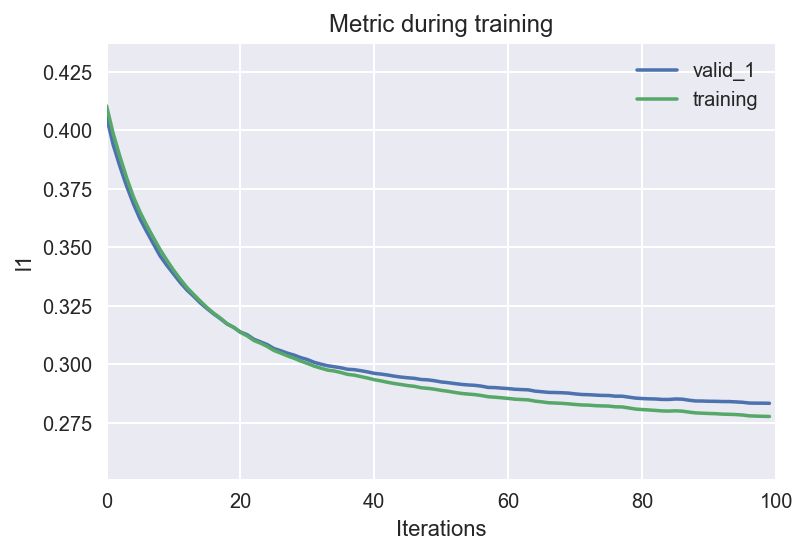

Plot feature importances...


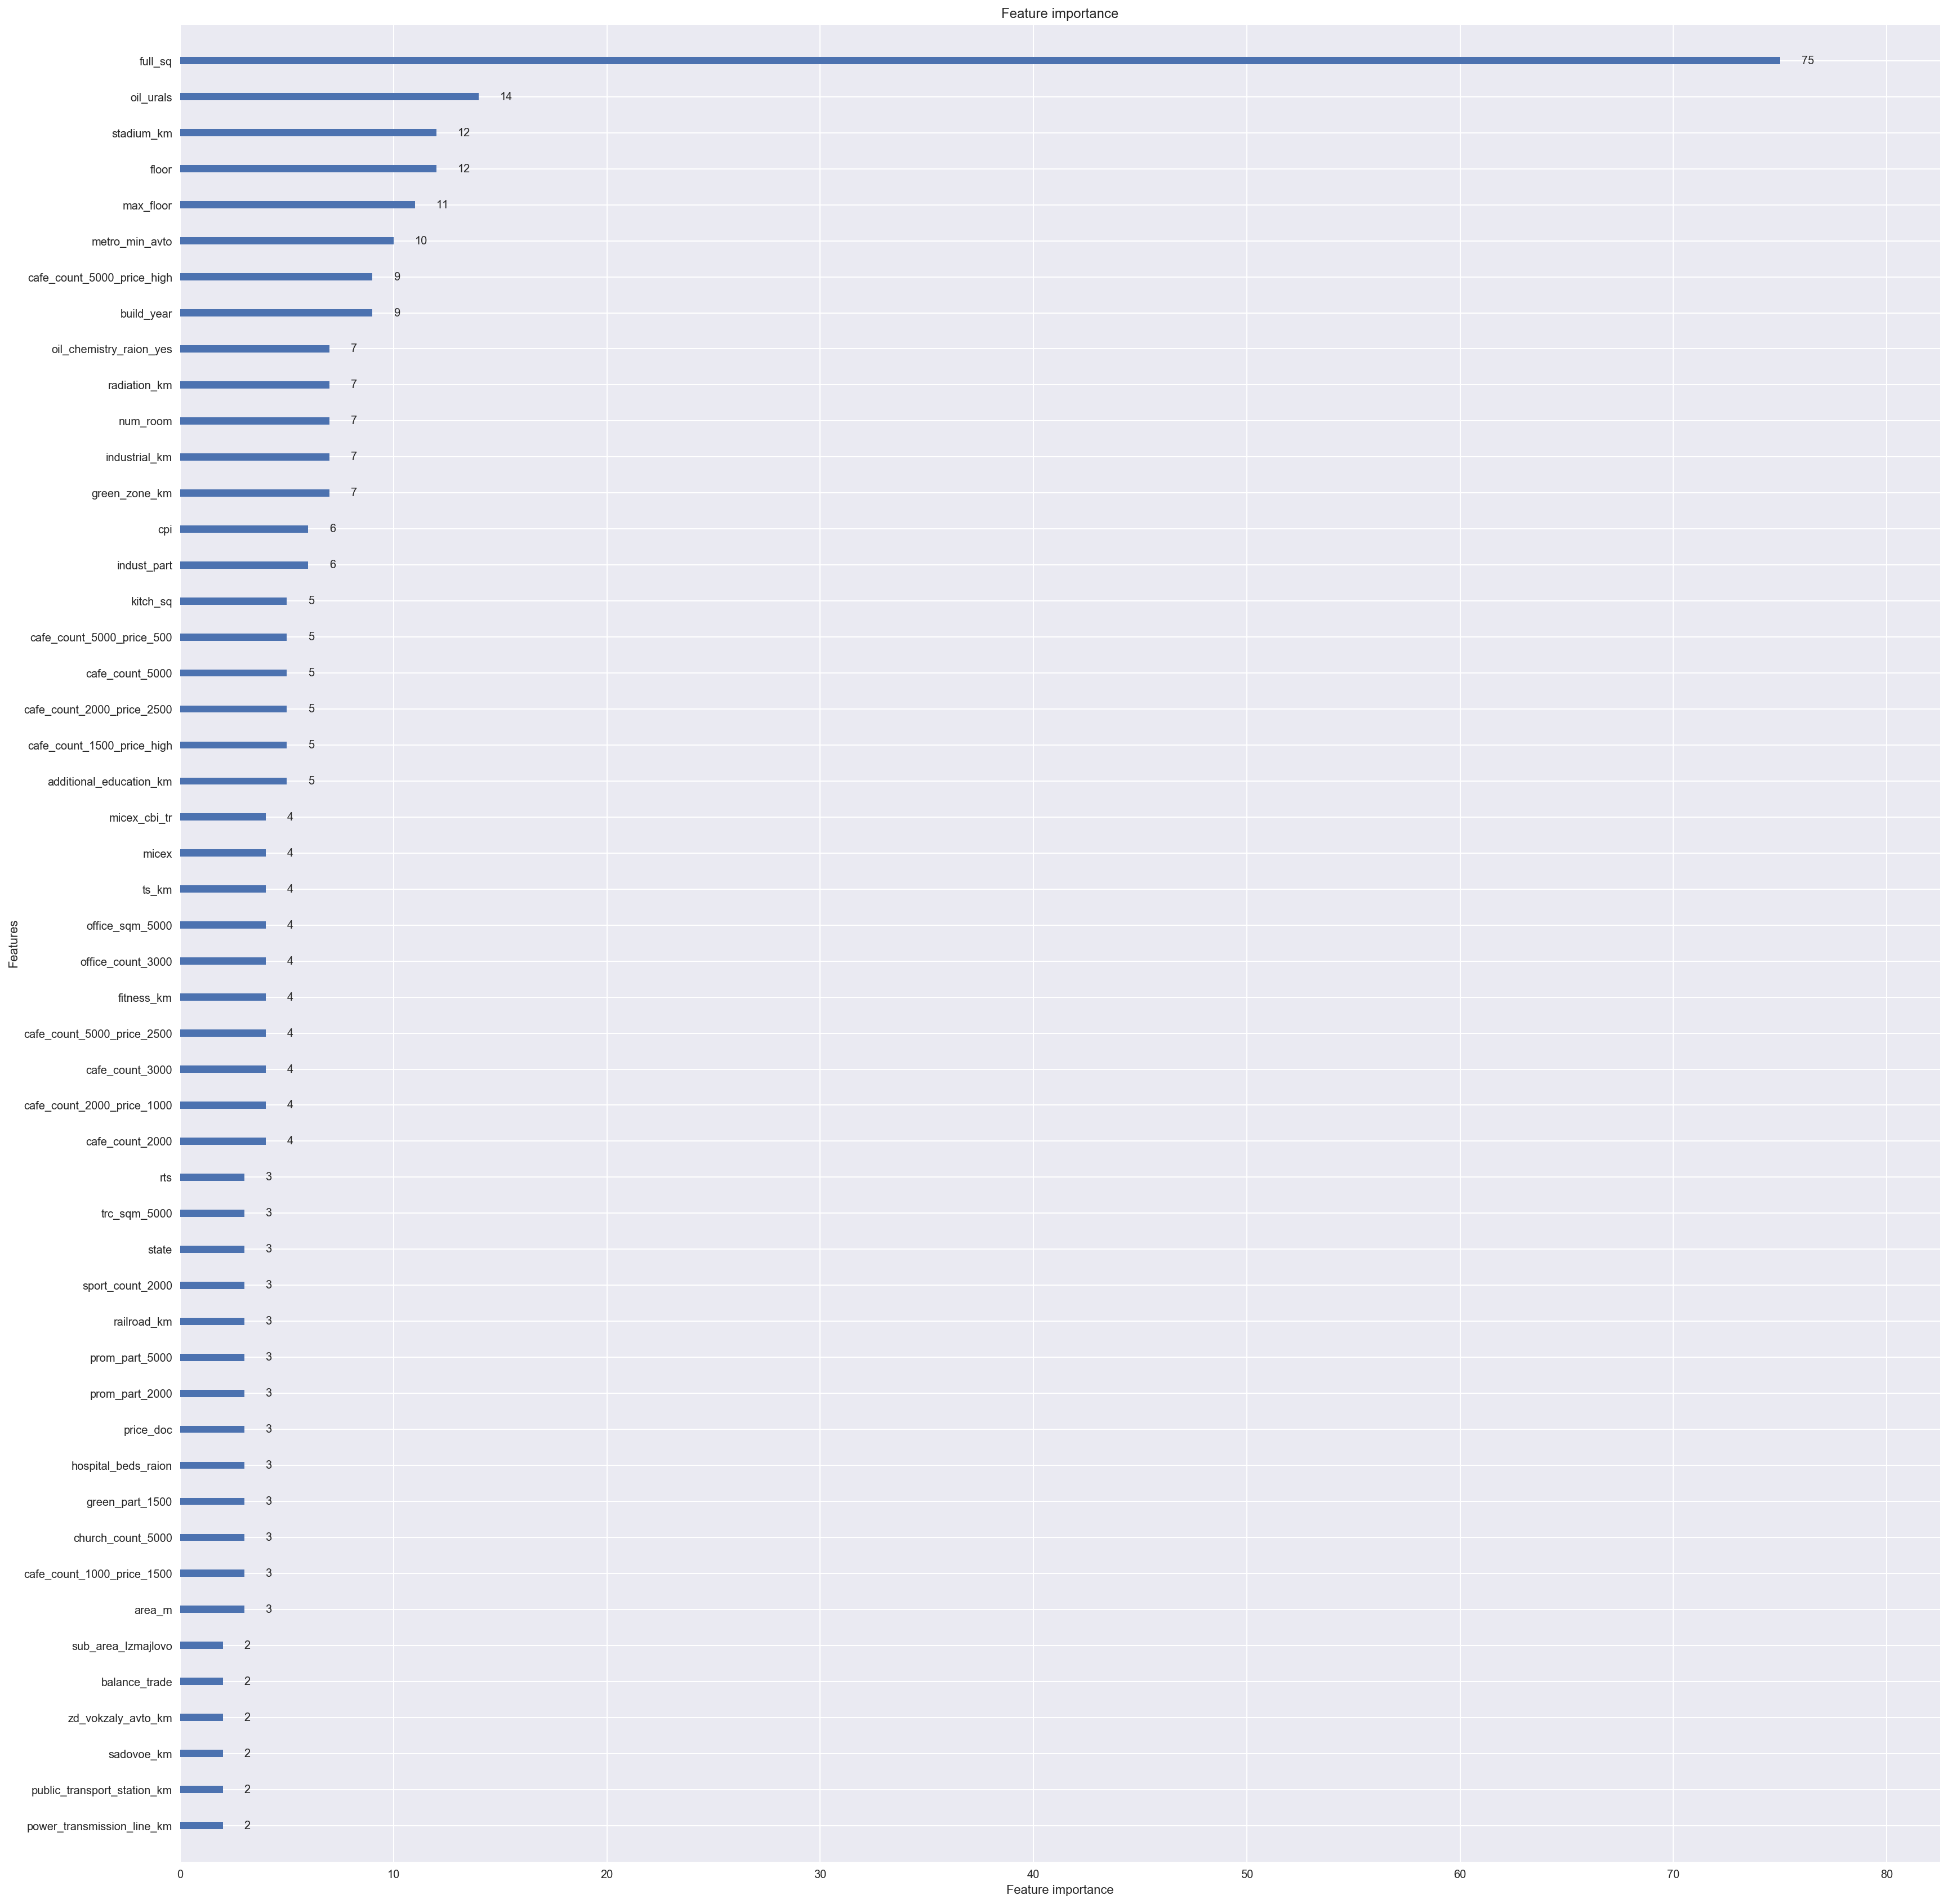

In [23]:
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='l1')
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=50, figsize=(28,30))

#print('Plot 84th tree...')  # one tree use categorical feature to split
#ax = lgb.plot_tree(gbm, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
#plt.show()

#print('Plot 84th tree with graphviz...')
#graph = lgb.create_tree_digraph(gbm, tree_index=83, name='Tree84')
#graph.render(view=True)

#### the score is high with TRAIN

In [31]:
# save model to file
gbm.save_model('model.txt')

# load model to predict
print('Load model to predict')
bst = lgb.Booster(model_file='model.txt')
# can only predict with the best iteration (or the saving iteration)
y_pred = bst.predict(validation[features].values) - offset
# eval with loaded model
print validation[features].values.shape
print validation['price_doc'].values.shape

print('The rmse of loaded model\'s prediction is:', mean_squared_error(y_pred , validation['price_doc']))


Load model to predict
(6095, 1897)
(6095,)
("The rmse of loaded model's prediction is:", 0.21764874923144523)


#### The score with TRAIN is more than FIT, need to work on model params in TRAIN
https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py